In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from utilities import *
import imageio
from io import BytesIO
from IPython.display import Image as DisplayImage


#%%
"""
Adapted from Zongyi Li TODO: include referene in the README
This file is the Fourier Neural Operator for 3D problem takes the 2D spatial + 1D temporal equation directly as a 3D problem
"""

import torch.nn.functional as F
from utilities import *
from timeit import default_timer

torch.manual_seed(0)
np.random.seed(0)
#%%
################################################################
# 3d fourier layers
################################################################


class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv3d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv3d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: all parameters  + encoded spatial-temporal locations (x, y, t)
        input shape: (batchsize, x=32, y=32, t=61, c=6)
        output: the solution of the 61 timesteps
        output shape: (batchsize, x=32, y=32, t=61, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 4 # pad the domain if input is non-periodic -. defautl 4 
        #TODO: padding = 4 

        self.p = nn.Linear(6, self.width)# input channel is 7: Por, Perm, gas_rate, Pressure + x, y, time encodings
        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x): # (batchsize, x=32, y=32, t=61, c=6)
        grid = self.get_grid(x.shape, x.device)
        #print(f'grid shape: {grid.shape}')
        #print(f'x shape: {x.shape}')
        #x = torch.cat((x, grid), dim=-1)
        #print(f'x shape after cat: {x.shape}')
        x = self.p(x) # output size: batchsize, channel , width
        x = x.permute(0, 4, 1, 2, 3)

        # TODO: modificar o padding para que ajustar x, y e t  
        #p3d -> x, y, t
        p3d = (self.padding, self.padding, self.padding, self.padding, self.padding, self.padding)
        x = F.pad(x, p3d) # pad the domain if input is non-periodic
        #x = F.pad(x, [0,self.padding]) # ORIGINAL
        x1 = self.conv0(x) #Fourier layer
        x1 = self.mlp0(x1) #Conv layer (input fourier layer output)
        x2 = self.w0(x) #Conv layer (input x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding] ORIGINAL
        #retirar o p3d referente aos ultimos 3 indices
        x = x[..., self.padding:-self.padding, self.padding:-self.padding, self.padding:-self.padding] 
        
        x = self.q(x)
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        return x


    def get_grid(self, shape, device):
        batchsize, size_x, size_y, size_z = shape[0], shape[1], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1, 1).repeat([batchsize, 1, size_y, size_z, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1, 1).repeat([batchsize, size_x, 1, size_z, 1])
        gridz = torch.tensor(np.linspace(0, 1, size_z), dtype=torch.float)
        gridz = gridz.reshape(1, 1, 1, size_z, 1).repeat([batchsize, size_x, size_y, 1, 1])
        return torch.cat((gridx, gridy, gridz), dim=-1).to(device)
        
      


/home/smrserraoseabr/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
#load normalizers from file and create a new normalizer object with the loaded values

# define all hardcoded variables and paths here

input_vars = ['Por', 'Perm', 'gas_rate'] # Porosity, Permeability, ,  Well 'gas_rate', Pressure + x, y, time encodings 
variable = 'Pressure'
output_vars = [variable] 


device = 'cpu'
folder = "/scratch/smrserraoseabr/Projects/FluvialCO2/results32/"
#folder = "/scratch/smrserraoseabr/Projects/NO-DA/CHECK"
num_files = 1000
traintest_split = 0.8

path_runs = f'runs/OK_ns_fourier_3d_N800.0_ep100_m12_w128_b61_padding4_{variable}'
model_name = f'ns_fourier_3d_N800.0_ep100_m12_w128_b61_padding4_{variable}'
path_model = os.path.join(path_runs, 'model', f'{model_name}.pt')

#path_model = '/scratch/smrserraoseabr/Projects/NO-DA/runs/OK_ns_fourier_3d_N800.0_ep100_m12_w128_b61_padding4_CO2/model/ns_fourier_3d_N800.0_ep100_m12_w128_b61_padding4_CO2.pt'
num_samples = 200  # Number of samples to iterate over



#END OF INPUTS ________________________________________________________________


if variable == 'CO_2':
    colorbar_vmax, colorbar_vmin = 0.0, 1.0 # Define your min and max here
elif variable == 'Pressure':
    colorbar_vmin, colorbar_vmax = 200.0, 600.0 # Define your min and max here
  # Change this to the index you want
image_folder = os.path.join('/scratch/smrserraoseabr/Projects/NO-DA/runs/TESTES/images')
#image_folder = '/scratch/smrserraoseabr/Projects/NO-DA/runs/OK_ns_fourier_3d_N800.0_ep100_m12_w128_b61_padding4_CO2/images'


model = torch.load(path_model)
model.eval()


FNO3d(
  (p): Linear(in_features=6, out_features=128, bias=True)
  (conv0): SpectralConv3d()
  (conv1): SpectralConv3d()
  (conv2): SpectralConv3d()
  (conv3): SpectralConv3d()
  (mlp0): MLP(
    (mlp1): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (mlp2): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (mlp1): MLP(
    (mlp1): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (mlp2): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (mlp2): MLP(
    (mlp1): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (mlp2): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (mlp3): MLP(
    (mlp1): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (mlp2): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (w0): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (w1): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (w2): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=

In [158]:
dataset = ReadXarray(folder=folder, input_vars=input_vars, output_vars=output_vars, num_files = num_files, traintest_split = traintest_split)
device = 'cpu'



test_a = dataset.test_data_input
test_u = dataset.test_data_output


test_a = test_a.to(device)
test_u = test_u.to(device)
#fix the seed for the random number generator
torch.manual_seed(1)
#test_a[0,:,:,:,1] = torch.rand(61,32,32)*10 #changing permeability for random number between 0 and 1

a_normalizer = UnitGaussianNormalizer(test_a, mean=torch.load(os.path.join(path_runs, 'model', f'{variable}_a_normalizer_mean.pt')), std=torch.load(os.path.join(path_runs, 'model', f'{variable}_a_normalizer_std.pt')))
y_normalizer = UnitGaussianNormalizer(test_u, mean=torch.load(os.path.join(path_runs, 'model', f'{variable}_y_normalizer_mean.pt')), std=torch.load(os.path.join(path_runs, 'model', f'{variable}_y_normalizer_std.pt')))





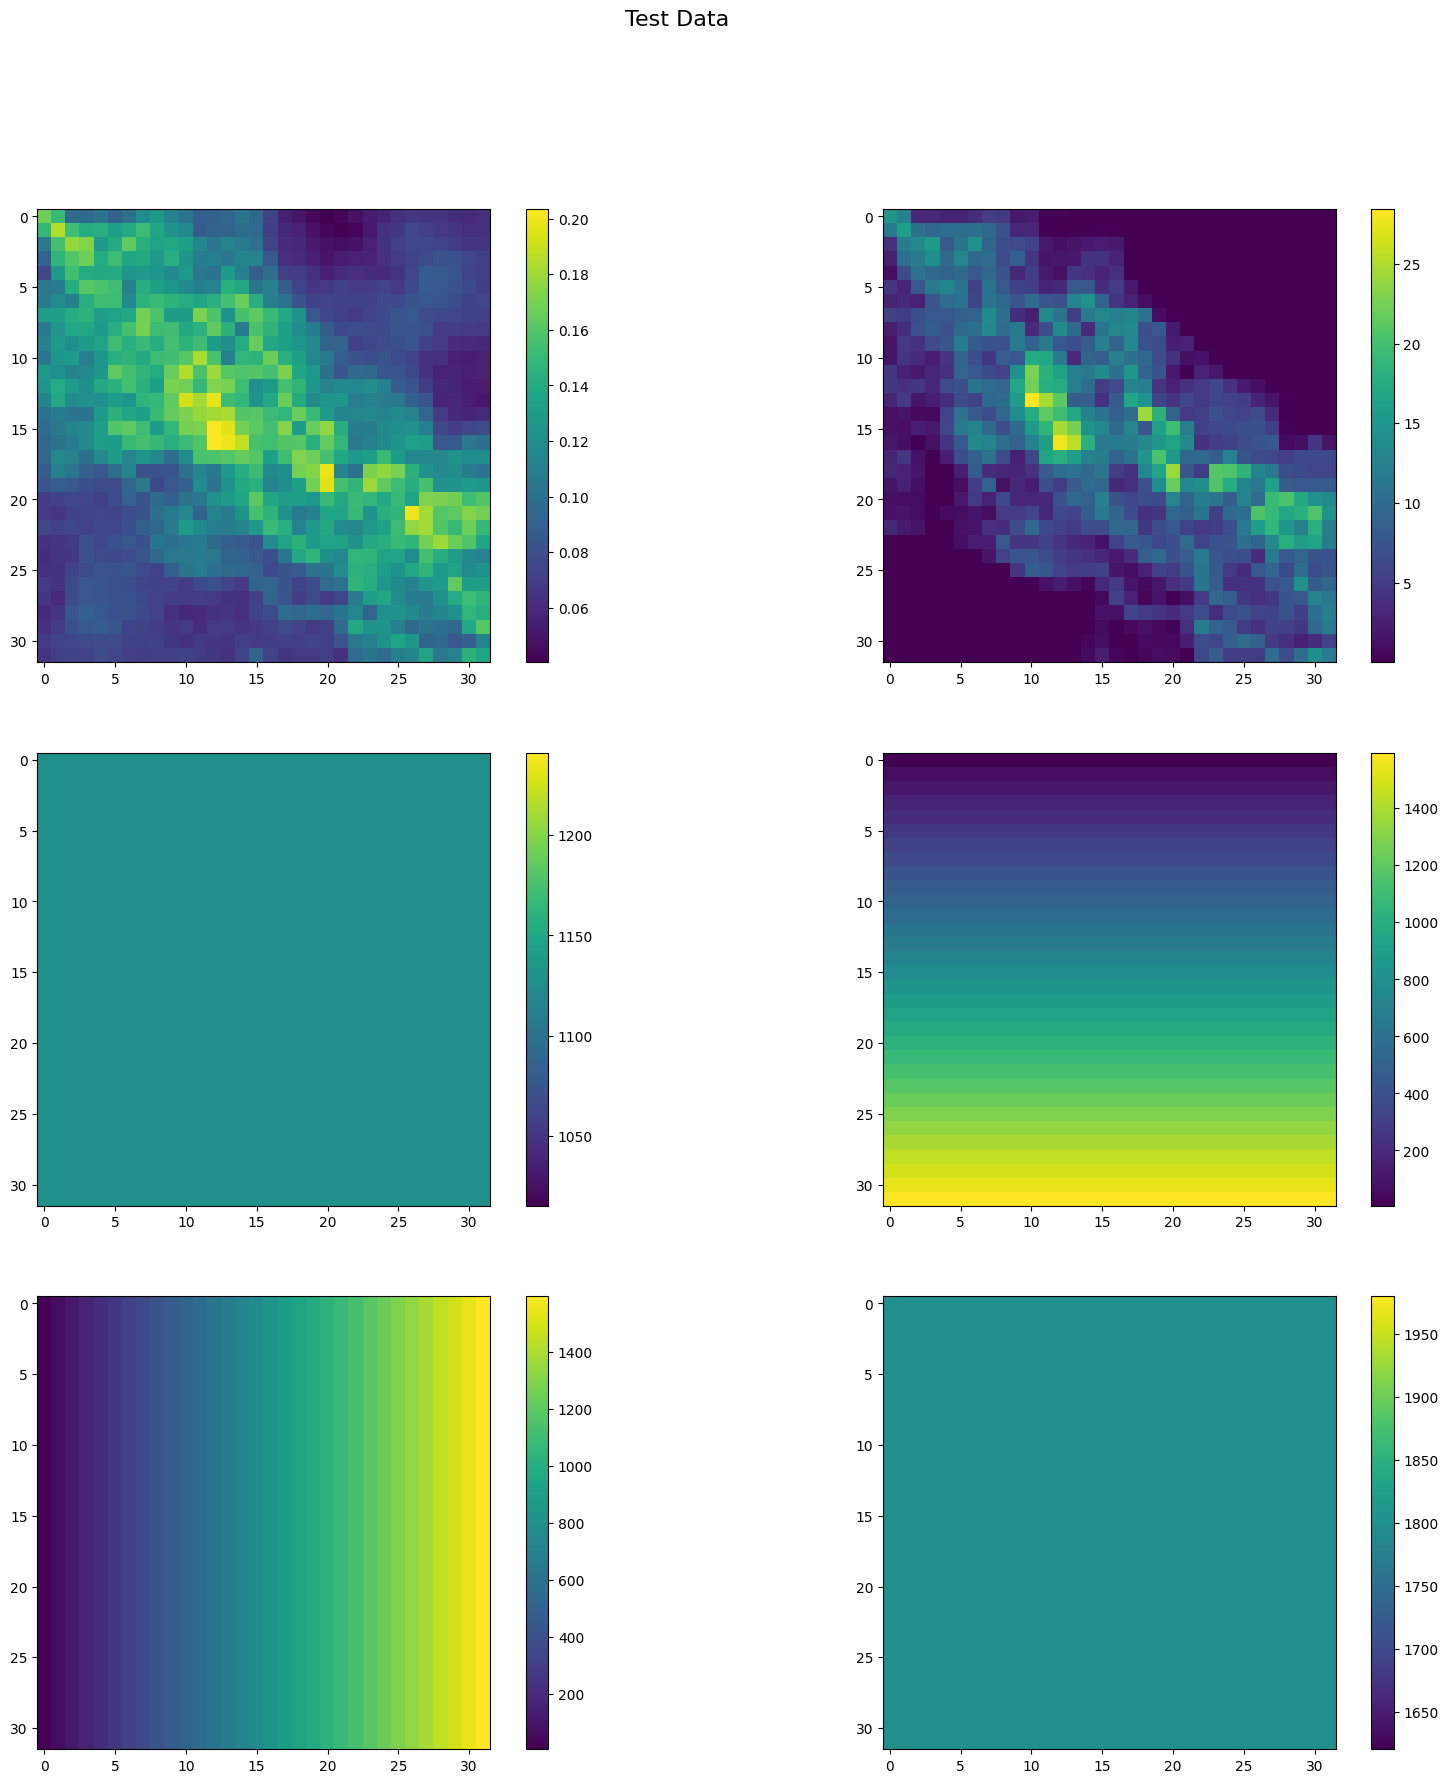

In [20]:
#plot test data - a figure with 6 subplots of the last timestep of the test data

fig = plt.figure(figsize=(20, 20))
fig.suptitle('Test Data', fontsize=16)
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.imshow(test_a[0, -1, :, :, i].cpu().detach().numpy())
    plt.colorbar()
    #plt.title(input_vars[i])
#plt.savefig(os.path.join(image_folder, f'test_data_{variable}.png'))

plt.show()

In [ ]:
test_a = a_normalizer.encode(test_a)
test_u = y_normalizer.encode(test_u)
true = y_normalizer.decode(test_u)

pred = model(test_a)
pred_un = y_normalizer.decode(pred)

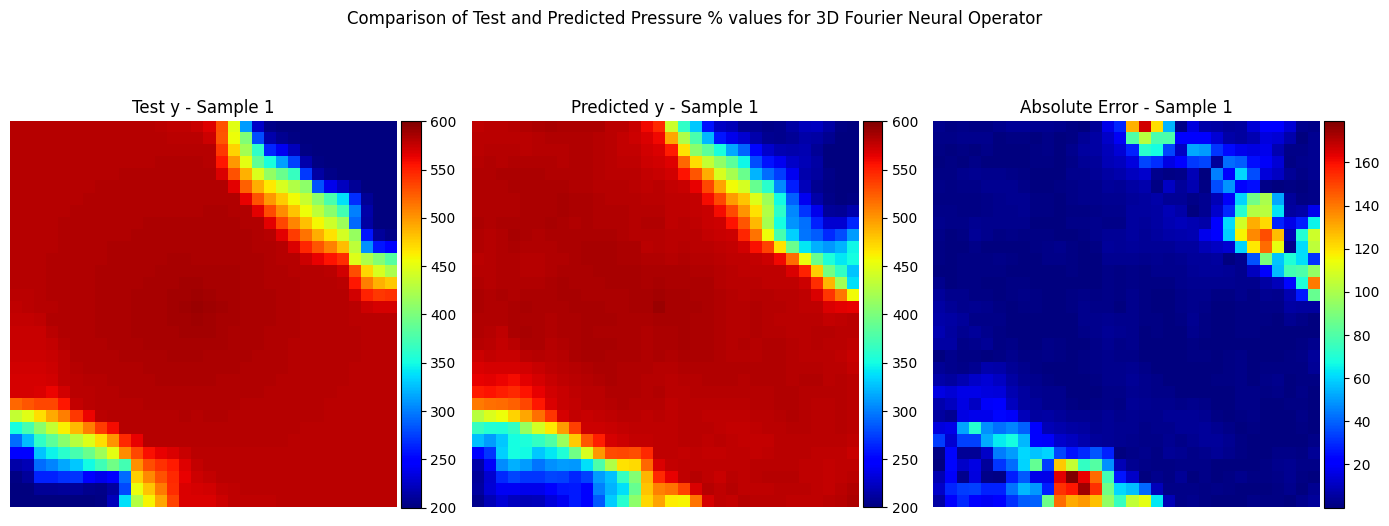

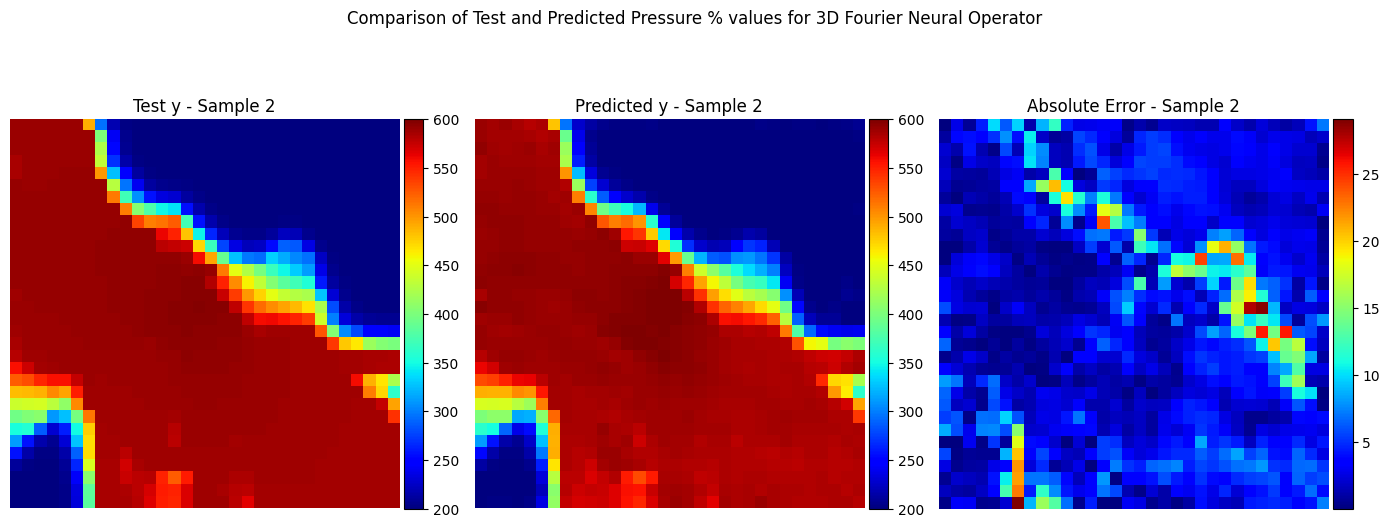

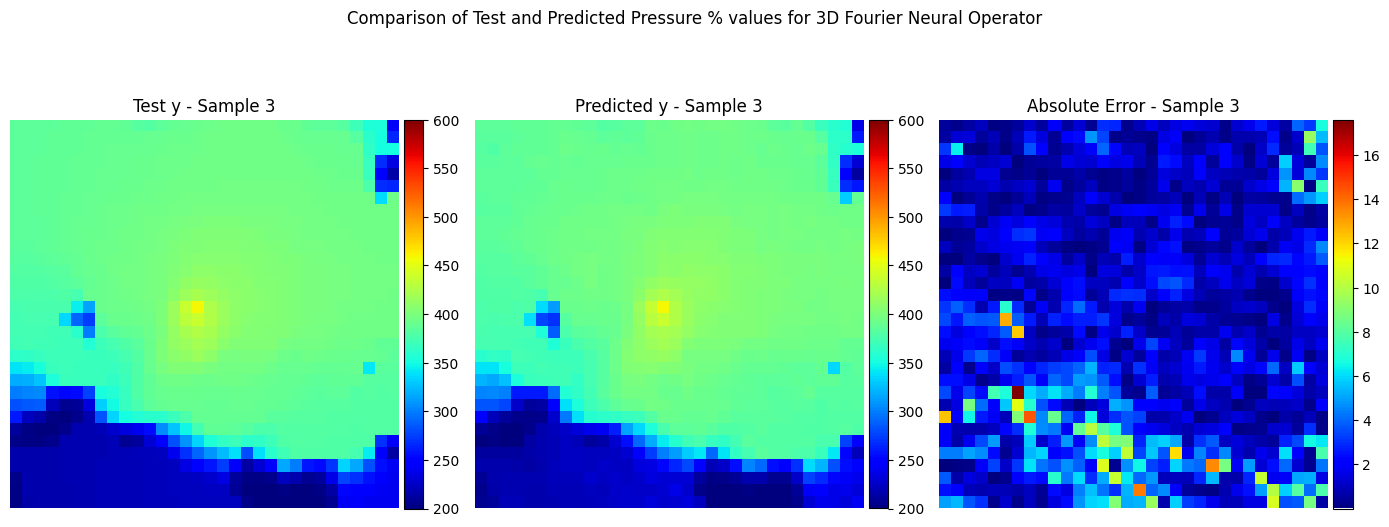

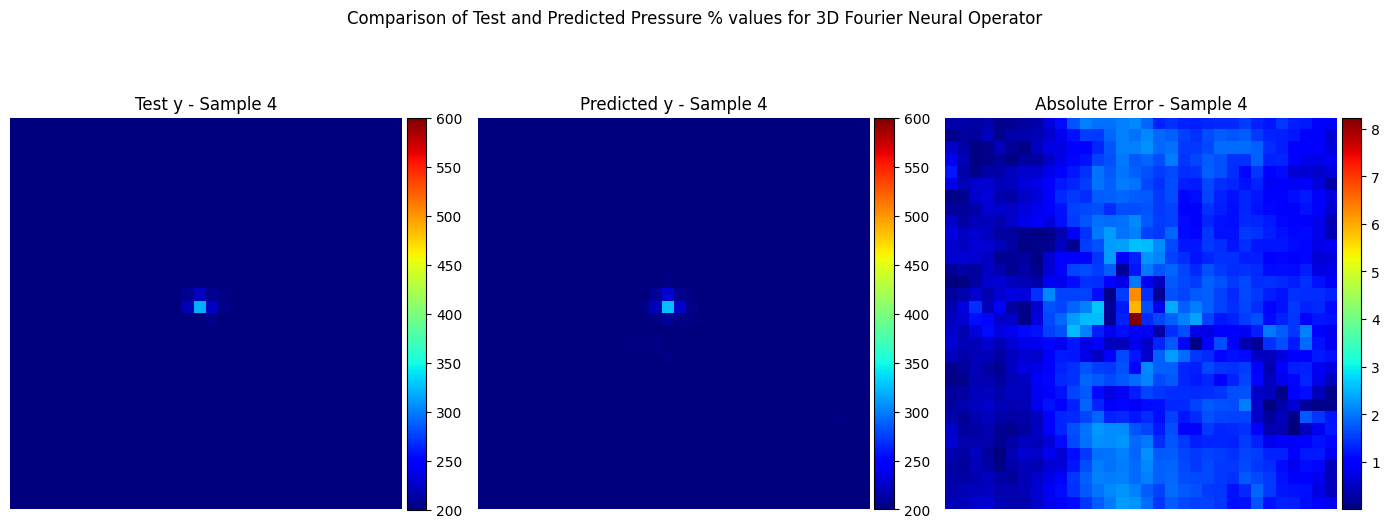

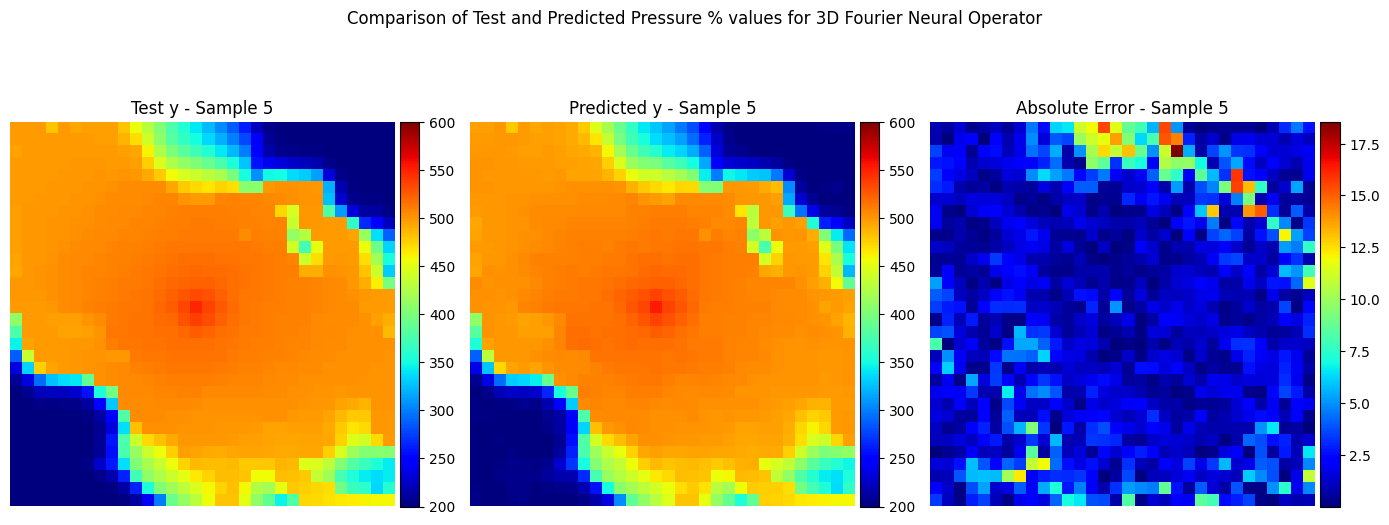

In [22]:
img_to_plot = 5
for index in range(img_to_plot):
    test_y = true[index,...].detach().numpy()
    predicted_y = pred_un[index,...].detach().numpy()

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))
    norm = mpl.colors.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax)

    img1 = axes[0].imshow(test_y[-1, :, :, 0], cmap='jet', norm=norm)
    img2 = axes[1].imshow(predicted_y[-1, :, :, 0], cmap='jet', norm=norm)
    img3 = axes[2].imshow(np.abs(test_y[ -1, :, :, 0] - predicted_y[ -1, :, :, 0]), cmap='jet')

    for img, ax in zip([img1, img2], axes[:2]):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(img, cax=cax, orientation='vertical')

    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img3, cax=cax, orientation='vertical')

    axes[0].set_title(f'Test y - Sample {index+1}')
    axes[1].set_title(f'Predicted y - Sample {index+1}')
    axes[2].set_title(f'Absolute Error - Sample {index+1}')

    for ax in axes:
        ax.axis('off')

    fig.suptitle(f'Comparison of Test and Predicted {variable} % values for 3D Fourier Neural Operator')
    plt.tight_layout()
    plt.show()
    #plt.savefig(os.path.join(image_folder, f"comparison_{index+1}.png"))
    plt.close()


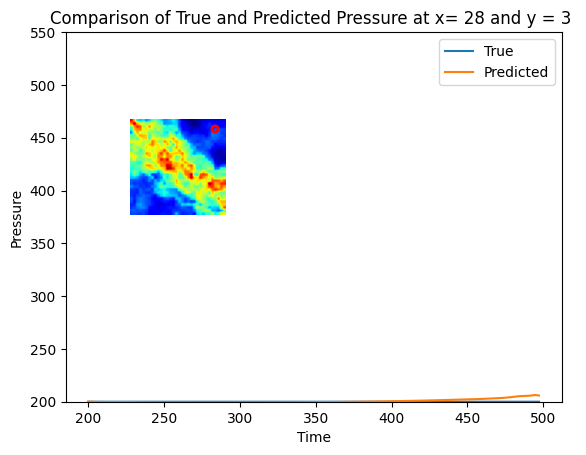

In [28]:
x= 28
y= 3
# Random data for illustration
time = test_y[:,0,0,0]


# Create main figure and axis
fig, main_ax = plt.subplots()

# Plot your data on the main axes
main_ax.plot(time, test_y[:, x, y, 0], label='True')
main_ax.plot(time, predicted_y[:, x, y, 0], label='Predicted')
main_ax.legend()

# Set labels and title for the main figure
main_ax.set_xlabel('Time')
main_ax.set_ylabel(variable)
main_ax.set_title(f'Comparison of True and Predicted Pressure at x= {x} and y = {y} ')

# Create inset of width 30% and height 30% at the upper right corner of the main plot
left, bottom, width, height = [0.2, 0.5, 0.2, 0.2] # adjust as needed
inset_ax = fig.add_axes([left, bottom, width, height])
im = inset_ax.imshow(test_a[0,-1, :, :, 0], cmap='jet')

inset_ax.scatter(x, y, s=20, edgecolor='red', facecolor='none', linewidth=2)

#fix scale of main plot between 0 and 1 

main_ax.set_ylim([200,550])



inset_ax.axis('off')
#save the figure with a name that includes the x and y coordinates and the variable name on the images folder

#fig.savefig(os.path.join('/scratch/smrserraoseabr/Projects/NO-DA/runs/OK_ns_fourier_3d_N800.0_ep100_m12_w128_b61_padding4_CO_2/blind_test/images', f'comparison_x{x}_y{y}CO_2.png'), dpi=300)

# Show the plot
plt.show()

In [32]:
pred_un.shape

torch.Size([200, 61, 32, 32, 1])

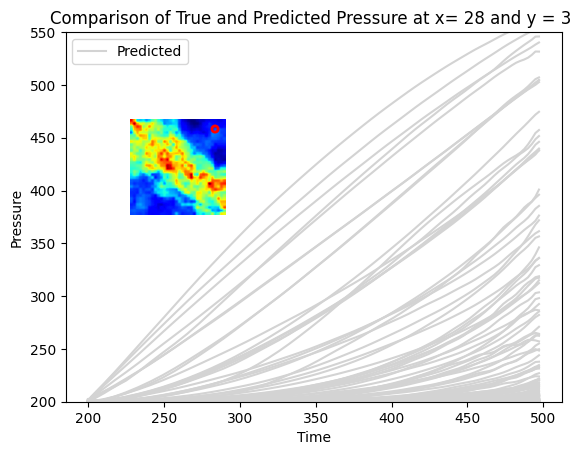

In [66]:
x= 28
y= 3
# Random data for illustration
time = test_y[:,0,0,0]


# Create main figure and axis
fig, main_ax = plt.subplots()

# Plot all models in light gray
for i in range(pred_un.detach().numpy() .shape[0]):
    main_ax.plot(time, pred_un.detach().numpy() [i,:, x, y, 0], color='lightgray')
main_ax.plot(time, pred_un.detach().numpy() [-1,:, x, y, 0], color='lightgray', label = 'Predicted')



# Plot your data on the main axes

#main_ax.plot(time, predicted_y[:, x, y, 0], label='Predicted')
main_ax.legend()

# Set labels and title for the main figure
main_ax.set_xlabel('Time')
main_ax.set_ylabel(variable)
main_ax.set_title(f'Comparison of True and Predicted Pressure at x= {x} and y = {y} ')

# Create inset of width 30% and height 30% at the upper right corner of the main plot
left, bottom, width, height = [0.2, 0.5, 0.2, 0.2] # adjust as needed
inset_ax = fig.add_axes([left, bottom, width, height])
im = inset_ax.imshow(test_a[0,-1, :, :, 0], cmap='jet')

inset_ax.scatter(x, y, s=20, edgecolor='red', facecolor='none', linewidth=2)

#fix scale of main plot between 0 and 1 

main_ax.set_ylim([200,550])
inset_ax.axis('off')

#save fig with a name that explains that this is the entire ensemble of predictions for the position x,y 
fig.savefig(os.path.join('/scratch/smrserraoseabr/Projects/NO-DA/runs/OK_ns_fourier_3d_N800.0_ep100_m12_w128_b61_padding4_Pressure/images', f'{num_samples}models_comparison_x{x}_y{y}_{variable}.png'), dpi=300)

#fig.savefig(os.path.join('/scratch/smrserraoseabr/Projects/NO-DA/runs/OK_ns_fourier_3d_N800.0_ep100_m12_w128_b61_padding4_CO_2/blind_test/images', f'comparison_x{x}_y{y}CO_2.png'), dpi=300)

# Show the plot
plt.show()

In [130]:
#find which models have a value above 500 at the last timestep for the position x,y, return the index 
#how to mand and on python?
condition = (pred_un.detach().numpy()[:,-1, x, y, -1]>250) & (pred_un.detach().numpy()[:,-1, x, y, -1]<350)
index = np.where(condition)
index


(array([  0,  27,  46,  60,  65,  68,  77,  81, 101, 117, 119, 123, 140,
        142, 151, 152, 156, 160, 174, 183]),)

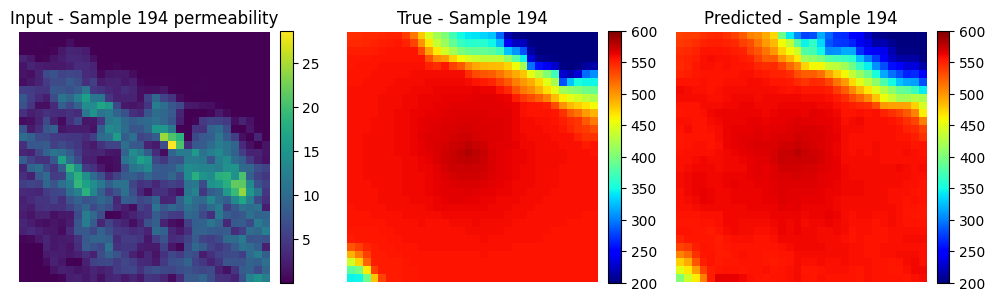

In [127]:
reference_model = 193
#create a figure with 3 subplots, one for the true, one for the predicted and one for the reference model
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
norm = mpl.colors.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax)
img1 = axes[0].imshow(a_normalizer.decode(test_a)[reference_model, -1,:, :, 1], cmap='viridis')
img2 = axes[1].imshow(true[reference_model, -1,:, :, 0], cmap='jet', norm=norm)
img3 = axes[2].imshow(pred_un.detach().numpy() [reference_model,-1, :, :, 0], cmap='jet', norm=norm)
fig.colorbar(img1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(img2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(img3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
axes[0].set_title(f'Input - Sample {reference_model+1} permeability')
axes[1].set_title(f'True - Sample {reference_model+1}')
axes[2].set_title(f'Predicted - Sample {reference_model+1}')
for ax in axes:
    ax.axis('off')

#including another prior model 


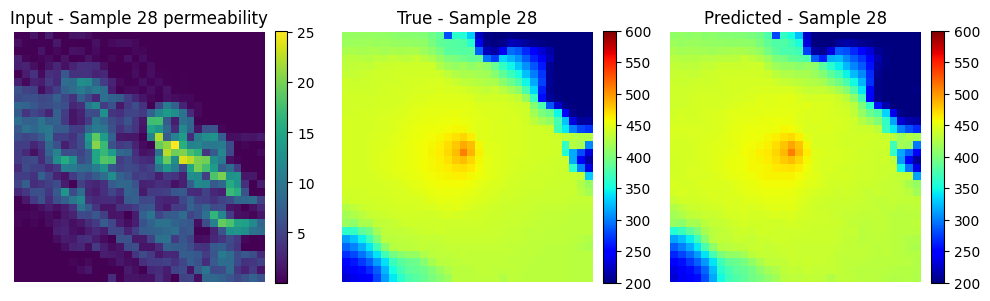

In [131]:
prior_model =27 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
norm = mpl.colors.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax)
img1 = axes[0].imshow(a_normalizer.decode(test_a)[prior_model, -1,:, :, 1], cmap='viridis')
img2 = axes[1].imshow(true[prior_model, -1,:, :, 0], cmap='jet', norm=norm)
img3 = axes[2].imshow(pred_un.detach().numpy() [prior_model,-1, :, :, 0], cmap='jet', norm=norm)
fig.colorbar(img1, ax=axes[0], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(img2, ax=axes[1], orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(img3, ax=axes[2], orientation='vertical', fraction=0.046, pad=0.04)
axes[0].set_title(f'Input - Sample {prior_model+1} permeability')
axes[1].set_title(f'True - Sample {prior_model+1}')
axes[2].set_title(f'Predicted - Sample {prior_model+1}')
for ax in axes:
    ax.axis('off')
    

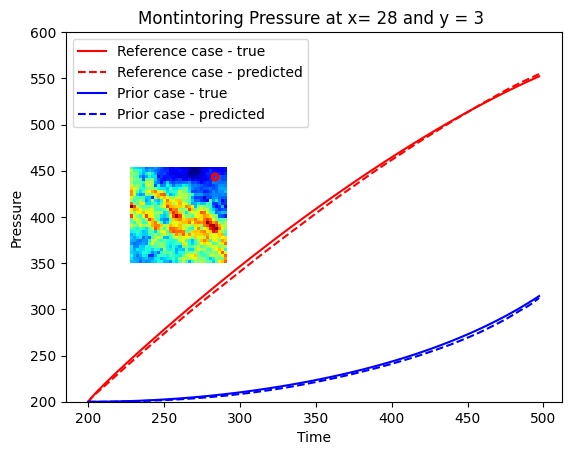

In [135]:

x= 28
y= 3

time = test_y[:,0,0,0]

# Create main figure and axis
fig, main_ax = plt.subplots()

# Plot all models in light gray

main_ax.plot(time, true.detach().numpy() [reference_model,:, x, y, 0], color='red', label = 'Reference case - true')
main_ax.plot(time, pred_un.detach().numpy() [reference_model,:, x, y, 0], color='red', linestyle ='--',  label = 'Reference case - predicted') 
main_ax.plot(time, true.detach().numpy() [prior_model,:, x, y, 0], color='blue', label = 'Prior case - true')
main_ax.plot(time, pred_un.detach().numpy() [prior_model,:, x, y, 0], color='blue', linestyle ='--',  label = 'Prior case - predicted')

main_ax.legend()


main_ax.set_xlabel('Time')

main_ax.legend()

# Set labels and title for the main figure
main_ax.set_xlabel('Time')
main_ax.set_ylabel(variable)
main_ax.set_title(f'Montintoring {variable} at x= {x} and y = {y} ')

# Create inset of width 30% and height 30% at the upper right corner of the main plot
left, bottom, width, height = [0.2, 0.4, 0.2, 0.2] # adjust as needed
inset_ax = fig.add_axes([left, bottom, width, height])
im = inset_ax.imshow(test_a[reference_model,-1, :, :, 0], cmap='jet')

inset_ax.scatter(x, y, s=20, edgecolor='red', facecolor='none', linewidth=2)

#fix scale of main plot between 0 and 1 

main_ax.set_ylim([200,600])
inset_ax.axis('off')

#save fig with a name that explains that this is the entire ensemble of predictions for the position x,y 
#fig.savefig(os.path.join('/scratch/smrserraoseabr/Projects/NO-DA/runs/OK_ns_fourier_3d_N800.0_ep100_m12_w128_b61_padding4_Pressure/images', f'{num_samples}models_comparison_x{x}_y{y}_{variable}.png'), dpi=300)

plt.show()

In [157]:
#list to store the predicted values and intermediate permeability values
predicted_values = []
permeability_values = []

#Define inputs for optimization 
#reference data
observed = true[reference_model,:, x, y, 0]
true_perm_map = a_normalizer.decode(test_a)[reference_model, -1,:, :, 1]


#prior data
prior_model_inputs = test_a[prior_model,:,:, :, :] 
prior_model_inputs = prior_model_inputs.unsqueeze(0)

predicted =  pred_un.detach().numpy()[prior_model,:, x, y, 0]
initial_perm_map = a_normalizer.decode(test_a)[prior_model, -1,:, :, 1]

IndexError: too many indices for array: array is 1-dimensional, but 5 were indexed

In [152]:
pred_un[0,:,x,y,0].shape #include a dimension for the batch size
observed.shape

torch.Size([61])

Step 0 of 10


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

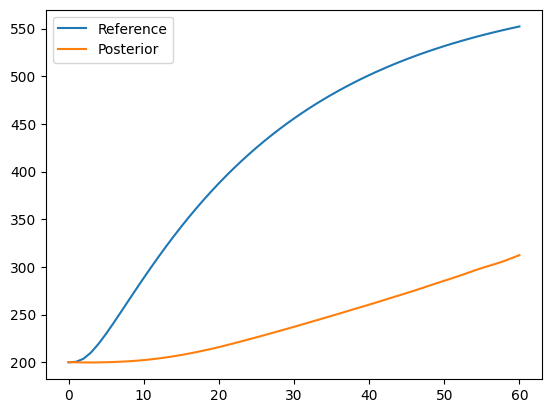

In [155]:
from torch import optim

# Define the loss function as the difference between observed data and predicted data
def loss_fn(observed, predicted):
    return ((observed - predicted)**2).mean()  # Mean Squared Error (MSE)

#use builtin

# Initialize the optimizer, we will use Adam here
optimizer = optim.Adam([prior_model_inputs[:,:,:,1]], lr=0.01)  # Adjust learning rate as needed

# Define the number of optimization steps
num_steps = 10


fig, ax = plt.subplots()

for step in range(num_steps):
    print(f'Step {step} of {num_steps}')
    optimizer.zero_grad()  # Clear previous gradients
    pred = model(prior_model_inputs)
    pred_un = y_normalizer.decode(pred)[0,:,x,y,0]   
    
    
    #loss = loss_fn(true, pred_un)  # Compute the loss WITH ALL DATA
    loss = loss_fn(observed, pred_un)  # Compute the loss WITH A SINGLE POINT

    loss.backward()  # Compute the gradients
    optimizer.step()  # Update the parameters using the gradients
    if step % 10 == 0:
        ax.clear()
        ax.plot(observed.detach().numpy(), label='Reference')
        ax.plot(pred_un.detach().numpy(), label='Posterior')
        ax.legend()
        plt.draw()
      

        # Store the current predicted values
        predicted_values.append(pred_un.detach().numpy())


plt.ioff()

In [19]:
fig, ax = plt.subplots()
pred = model(test_a)
pred_un = y_normalizer.decode(pred)
predicted_y = pred_un[0,:, x, y, 0]     

ax.clear()
ax.plot(test_y[:, x, y, 0], label='True')
ax.plot(predicted_y.detach().numpy(), label='Predicted')
plt.draw()

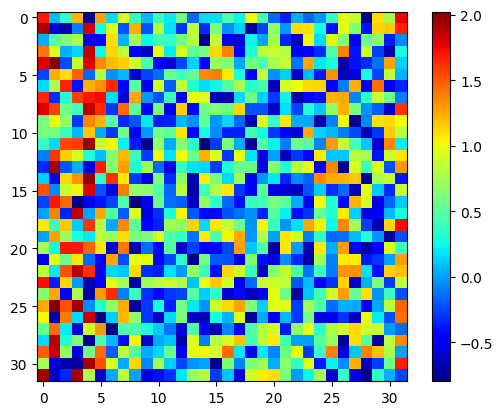

In [25]:
plt.imshow(test_a[0,0,:,:,1], cmap='jet')
#include colorbar
plt.colorbar()
plt.show()